In [1]:
# %pip install astropy
# %pip install scipy
# %pip install matplotlib
# %pip install astroquery
# %pip install skyfield

In [2]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import math
from datetime import datetime, timezone, timedelta

# NEW: Import telescope and sensor configuration
from instrument_config import TelescopeConfig, SensorConfig

from synthetic_image import (
    get_star_catalog,
    build_synthetic_wcs,
    world_to_pixel,
    mag_to_flux,
    add_psf_to_image,
    make_gaussian_psf,
    make_moffat_psf,
    sky_brightness_to_electrons,
    add_satellite_substepping,
    add_star_trails_skyfield,
    add_star_trails_fixed_camera
)
from skyfield.api import load, wgs84, Star


In [3]:
# Example usage of the new API
telescope = TelescopeConfig(
    focal_length_mm=1020.0,
    aperture_mm=204.0,
    image_circle_mm=50.0
)

sensor = SensorConfig(
    pixel_size_um=4.95,
    sensor_width_px=4144,
    sensor_height_px=2822,
    full_well_capacity_e=30000,
    quantum_efficiency=0.8,
    read_noise_e=5.0
)

computed_pixscale_arcsec = sensor.compute_pixel_scale_arcsec(telescope)
fov_x_deg, fov_y_deg = sensor.compute_fov_degrees(telescope)

# For demonstration, we'll keep the originally hard-coded value.
ra_center = 88.29533   # degrees
dec_center = -5.364887 # degrees
rotation_degrees = -52.0

max_mag = 14.5 #15.5
seeing_arcsec = 5.5
pixscale_arcsec = computed_pixscale_arcsec

# Fictional camera/telescope parameters
exposure_time      = 2.0     # seconds
sky_mag_per_arcsec2 = 18.5   # mag/arcsec^2
mag_zero_point     = 15.5

print(f"Pixel scale from config: {computed_pixscale_arcsec:.3f} arcsec/pixel")
print(f"Aperture area from config: {telescope.aperture_area_cm2:.2f} cm^2")
print(f"F-ratio from config: f/{telescope.f_ratio:.2f}")
print(f"Computed FoV: {fov_x_deg:.2f}° (H) x {fov_y_deg:.2f}° (V)")

Pixel scale from config: 1.001 arcsec/pixel
Aperture area from config: 326.85 cm^2
F-ratio from config: f/5.00
Computed FoV: 1.15° (H) x 0.78° (V)


In [4]:
wcs_obj, wcs_header = build_synthetic_wcs(
    image_width=sensor.sensor_width_px,
    image_height=sensor.sensor_height_px,
    ra_center=ra_center,
    dec_center=dec_center,
    pixscale_arcsec=computed_pixscale_arcsec,
    rotation_degrees=rotation_degrees
)

In [5]:
# Create an empty image
synthetic_image = np.zeros((sensor.sensor_height_px, sensor.sensor_width_px), dtype=float)

In [6]:
diagonal_fov_deg = math.sqrt(fov_x_deg**2 + fov_y_deg**2)
search_radius_deg = diagonal_fov_deg / 2.0

print(f"Using a search radius of ~{search_radius_deg:.2f} deg")

star_catalog = get_star_catalog(ra_center, dec_center, radius=search_radius_deg, max_mag=max_mag)
if star_catalog is None or len(star_catalog) == 0:
    print('No stars returned by catalog query. You may need to use a brighter max_mag or larger radius.')
else:
    print(f'Successfully retrieved {len(star_catalog)} stars.')
fwhm_pixels = seeing_arcsec / computed_pixscale_arcsec

Using a search radius of ~0.70 deg
Successfully retrieved 647 stars.


In [7]:
# Create a Moffat PSF
psf_kernel = make_moffat_psf(
    size=int(fwhm_pixels * 6),
    fwhm=fwhm_pixels,
    moffat_alpha=4
)
# plt.imshow(psf_kernel, cmap='gray')
# plt.colorbar()
# plt.title('PSF Kernel')
# plt.show()

In [8]:
# Add sky background
sky_bg = sky_brightness_to_electrons(
    sky_mag_per_arcsec2,
    plate_scale_arcsec_per_pix=computed_pixscale_arcsec,
    exposure_time=exposure_time,
    quantum_efficiency=sensor.quantum_efficiency,
    aperture_area=telescope.aperture_area_cm2,
    mag_zero_point=mag_zero_point
)
synthetic_image += sky_bg

In [9]:
# Example: set the exposure time to 600 seconds or so, and find if the star might be above horizon.
start_time = datetime(2025, 1, 10, 9, 0, 0, tzinfo=timezone.utc)
end_time = start_time + timedelta(seconds=exposure_time)
num_sub_steps = 20

# 1) Compute alt0, az0 that correspond to the RA/Dec center at start_time.
ts = load.timescale()
t0 = ts.from_datetime(start_time)
planets = load('de421.bsp')
earth = planets['earth']
site = earth + wgs84.latlon(34.05, -118.25, elevation_m=100.0)
center_star = Star(ra_hours=ra_center/15.0, dec_degrees=dec_center)
app_center = site.at(t0).observe(center_star).apparent()
alt_center, az_center, dist_center = app_center.altaz()
alt0_guess = alt_center.degrees
az0_guess  = az_center.degrees
print(f'Computed alt0={alt0_guess:.2f}°, az0={az0_guess:.2f}° at start time')

Computed alt0=36.53°, az0=230.14° at start time


In [10]:
# 2) Use alt0_guess, az0_guess in add_star_trails_fixed_camera
if star_catalog is not None and len(star_catalog) > 0:
    add_star_trails_fixed_camera(
        image=synthetic_image,
        star_catalog=star_catalog,
        lat_deg=34.05,
        lon_deg=-118.25,
        alt_m=100.0,
        start_time=start_time,
        end_time=end_time,
        num_sub_steps=num_sub_steps,
        aperture_area=telescope.aperture_area_cm2,
        quantum_efficiency=sensor.quantum_efficiency,
        mag_zero_point=mag_zero_point,
        psf_kernel=psf_kernel,
        extinction=0.5,
        camera_rotation_deg=-90.0,
        arcsec_per_pix=computed_pixscale_arcsec,
        alt0=alt0_guess,
        az0=az0_guess
    )
else:
    print('Skipping star trails because no star_catalog data was returned.')

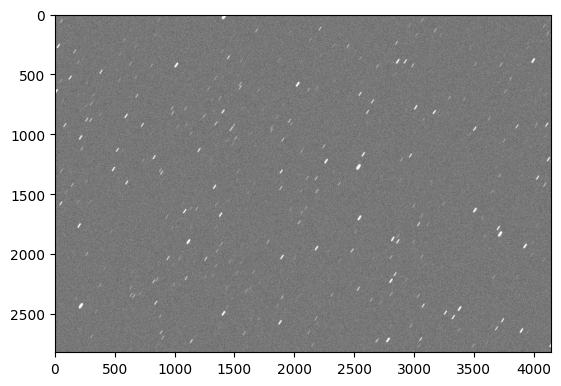

In [11]:
# Optional: Add noise
read_noise_e = sensor.read_noise_e
noisy_image = np.random.poisson(synthetic_image) + np.random.normal(loc=0.0, scale=read_noise_e, size=synthetic_image.shape)
noisy_image = np.fliplr(noisy_image)  # optional flip
plt.imshow(noisy_image, cmap='gray', vmin=np.percentile(noisy_image, 0.5), vmax=np.percentile(noisy_image, 99.5))
plt.show()

In [12]:
# Save to FITS with WCS from earlier (just referencing ra_center/dec_center at start)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
wcs_header["EXPTIME"] = (exposure_time, "Exposure time in seconds")
wcs_header["DATE-OBS"] = (start_time.strftime("%Y-%m-%dT%H:%M:%S"), "UTC date/time of observation start")
wcs_header["TELESCOP"] = ("Simulator", "Telescope name")
wcs_header["PIXSCALE"] = (computed_pixscale_arcsec, "Plate scale in arcsec/pixel")
wcs_header["RA"] = (ra_center, "Right Ascension in degrees")
wcs_header["DEC"] = (dec_center, "Declination in degrees")
wcs_header["RADECSYS"] = ("ICRS", "Right Ascension and Declination system")
wcs_header["FOVX"] = (fov_x_deg, "Horizontal field of view in degrees")
wcs_header["FOVY"] = (fov_y_deg, "Vertical field of view in degrees")

hdu = fits.PrimaryHDU(data=noisy_image, header=wcs_header)
output_filename = f"output/synthetic_image_{timestamp}.fits"
hdu.writeto(output_filename, overwrite=True)
print(f"Synthetic image saved to {output_filename}")

Synthetic image saved to output/synthetic_image_20250117_112047.fits
